In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline, make_interp_spline

%matplotlib inline

In [58]:
class PID_Controller_c:

    def __init__(self, KP = 0.0, KI = 0.0, KD = 0.0, maxOutput = 0.0, maxIOutput = 0.0):

        self.KP = KP
        self.KI = KI
        self.KD = KD

        self.error = [0.0, 0.0, 0.0]
        self.diff = [0.0, 0.0, 0.0]

        self.Pout = 0.0
        self.Iout = 0.0
        self.Dout = 0.0
        
        self.sepaFlag = 0
        self.changeRate = 1.0

        self.output = 0.0
        self.maxOutput = maxOutput
        self.maxIOutput = maxIOutput

    def ClearPID(self):

        self.KP = 0.0
        self.KI = 0.0
        self.KD = 0.0

        self.error = [0.0, 0.0, 0.0]
        self.diff = [0.0, 0.0, 0.0]

        self.Pout = 0.0
        self.Iout = 0.0
        self.Dout = 0.0

    def LimitOutput(self, output, limitOutput):

        if(output > limitOutput):
            output = limitOutput
        elif(output < -limitOutput):
            output = -limitOutput

        return output

    def PositionMode(self, feedback, target):
        # 位置式 PID
        self.feedback = feedback
        self.target = target
        self.error[2] = self.error[1]
        self.error[1] = self.error[0]
        self.error[0] = target - feedback

        self.Pout = self.KP * self.error[0]
        self.Iout += self.KI * self.error[0]
        self.diff[2] = self.diff[1]
        self.diff[1] = self.diff[0]
        self.diff[0] = (self.error[0] - self.error[1])
        self.Dout = self.KD * self.diff[0]
        self.Iout = self.LimitOutput(self.Iout, self.maxIOutput)
        self.output = self.Pout + self.Iout + self.Dout
        self.output = self.LimitOutput(self.output, self.maxOutput)
        
        return self.output 

    def IncrementMode(self, feedback, target):
        # 增量式 PID
        self.feedback = feedback
        self.target = target
        self.error[2] = self.error[1]
        self.error[1] = self.error[0]
        self.error[0] = target - feedback

        self.Pout = self.KP * (self.error[0] - self.error[1])
        self.Iout = self.KI * self.error[0]
        self.diff[2] = self.diff[1]
        self.diff[1] = self.diff[0]
        self.diff[0] = (self.error[0] - 2 * self.error[1] + self.error[2])
        self.Dout = self.KD * self.diff[0]
        self.output += self.Pout + self.Iout + self.Dout
        self.output = self.LimitOutput(self.output, self.maxOutput)

        return self.output
    
    def IntegralSeparation(self, feedback, target):
        # 积分分离 PID
        self.feedback = feedback
        self.target = target
        self.error[2] = self.error[1]
        self.error[1] = self.error[0]
        self.error[0] = target - feedback
        
        if(abs(self.error[0]) > 0.5):
            self.sepaFlag = 0
        else:
            self.sepaFlag = 1

        self.Pout = self.KP * self.error[0]
        self.Iout += self.KI * self.error[0]
        self.diff[2] = self.diff[1]
        self.diff[1] = self.diff[0]
        self.diff[0] = (self.error[0] - self.error[1])
        self.Dout = self.KD * self.diff[0]
        self.Iout = self.LimitOutput(self.Iout, self.maxIOutput)
        self.output = self.Pout + self.sepaFlag * self.Iout + self.Dout
        self.output = self.LimitOutput(self.output, self.maxOutput)
        
        return self.output 
    
    def AntiIntegralSaturated(self, feedback, target):
        # 抗积分饱和 PID
        self.feedback = feedback
        self.target = target
        self.error[2] = self.error[1]
        self.error[1] = self.error[0]
        self.error[0] = target - feedback
        
        if(abs(self.output) > self.maxOutput):
            if(self.output > 0):
                if(abs(self.error[0]) > 0.5):
                    self.sepaFlag = 0
                else:
                    self.sepaFlag = 1
                    if(self.error[0] < 0):
                        self.Iout += self.KI * self.error[0]
            if(self.output < 0):
                if(abs(self.error[0]) > 0.5):
                    self.sepaFlag = 0
                else:
                    self.sepaFlag = 1
                    if(self.error[0] > 0):
                        self.Iout += self.KI * self.error[0]
        else:
            if(abs(self.error[0]) > 0.5):
                self.sepaFlag = 0
            else:
                self.sepaFlag = 1  

        self.Pout = self.KP * self.error[0]
        self.Iout += self.KI * self.error[0]
        self.diff[2] = self.diff[1]
        self.diff[1] = self.diff[0]
        self.diff[0] = (self.error[0] - self.error[1])
        self.Dout = self.KD * self.diff[0]
        self.Iout = self.LimitOutput(self.Iout, self.maxIOutput)
        self.output = self.Pout + self.sepaFlag * self.Iout + self.Dout
        self.output = self.LimitOutput(self.output, self.maxOutput)
        
        return self.output 
    
    def TrapezoidIntegral(self, feedback, target):
        # 梯形积分 PID
        self.feedback = feedback
        self.target = target
        self.error[2] = self.error[1]
        self.error[1] = self.error[0]
        self.error[0] = target - feedback
        
        if(abs(self.output) > self.maxOutput):
            if(self.output > 0):
                if(abs(self.error[0]) > 0.5):
                    self.sepaFlag = 0
                else:
                    self.sepaFlag = 1
                    if(self.error[0] < 0):
                        self.Iout += self.KI * self.error[0]
            if(self.output < 0):
                if(abs(self.error[0]) > 0.5):
                    self.sepaFlag = 0
                else:
                    self.sepaFlag = 1
                    if(self.error[0] > 0):
                        self.Iout += self.KI * self.error[0]
        else:
            if(abs(self.error[0]) > 0.5):
                self.sepaFlag = 0
            else:
                self.sepaFlag = 1  

        self.Pout = self.KP * self.error[0]
        self.Iout += self.KI * self.error[0]
        self.diff[2] = self.diff[1]
        self.diff[1] = self.diff[0]
        self.diff[0] = (self.error[0] - self.error[1])
        self.Dout = self.KD * self.diff[0]
        self.Iout = self.LimitOutput(self.Iout, self.maxIOutput)
        self.output = self.Pout + self.sepaFlag * self.Iout / 2 + self.Dout
        self.output = self.LimitOutput(self.output, self.maxOutput)
        
        return self.output
    
    def ChangedIntegral(self, feedback, target):
        # 变积分 PID
        self.feedback = feedback
        self.target = target
        self.error[2] = self.error[1]
        self.error[1] = self.error[0]
        self.error[0] = target - feedback
        
        if(abs(self.error[0]) > 1):
            self.changeRate = 0
        elif(abs(self.error[0]) > 0.5):
            self.changeRate = 0.5
        else:
            self.changeRate = 1

        self.Pout = self.KP * self.error[0]
        self.Iout += self.KI * self.error[0]
        self.diff[2] = self.diff[1]
        self.diff[1] = self.diff[0]
        self.diff[0] = (self.error[0] - self.error[1])
        self.Dout = self.KD * self.diff[0]
        self.Iout = self.LimitOutput(self.Iout, self.maxIOutput)
        self.output = self.Pout + self.changeRate * self.Iout + self.Dout
        self.output = self.LimitOutput(self.output, self.maxOutput)
        
        return self.output

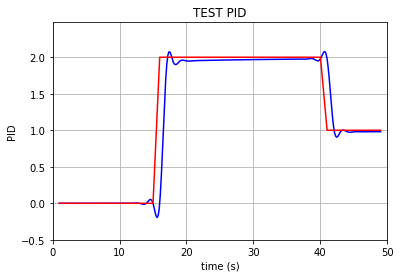

In [55]:
def drawPID():

    KP = 0.95
    KI = 0.001
    KD = 0.0
    maxOutput = 3
    maxIOutput = 0.5

    loopNum = 50
    target = 0.0
    feedback = 0.0


    pidController = PID_Controller_c(KP, KI, KD, maxOutput, maxIOutput)
    
    feedbackList = []
    timeList = []
    targetList = []

    for i in range(1, loopNum):
        pidController.AntiIntegralSaturated(feedback, target)
        output = pidController.output

        if(target > 0):
            feedback += (output - (1/i))

        if(i > 15):
            target = 2 
        if(i > 40):
            target = 1

        
        feedbackList.append(feedback)
        targetList.append(target)
        timeList.append(i)


    timeSM = np.array(timeList)
    # 在指定的间隔内返回均匀间隔的数字
    timeSmooth = np.linspace(timeSM.min(), timeSM.max(), 300)
    # 拟合一条曲线 - 拟合后，曲线才能绘制出来
    feedbackSmooth = make_interp_spline(timeList, feedbackList)(timeSmooth)
    
    plt.plot(timeSmooth, feedbackSmooth, color='b')
    plt.plot(timeList, targetList, color='r')
    plt.xlim((0, loopNum))
    plt.ylim((min(feedbackList)-0.5, max(feedbackList)+0.5))
    plt.xlabel('time (s)')
    plt.ylabel('PID')
    plt.title('TEST PID')

    plt.grid(True)
    plt.show()

drawPID() 